Capstone 2 Project - Springboard - Wesley Hall

Project Objective:
Predict the future spatial distribution of technology startups in Los Angeles based on business registration data, educational attainment metrics, and temporal factors. Relevance:Understanding how educational demographics and temporal trends influence business clustering can inform targeted urban development and economic policies.

Data Description

Dataset 1: Business Registrations https://data.lacity.org/Administration-Finance/Listing-of-Active-Businesses/6rrh-rzua/data Contains business registrations categorized by NAICS codes, addresses with zip codes, geographical coordinates (latitude, longitude), and dates of registrations.  

Dataset 2: Educational Attainment https://data.census.gov/table?q=educational%20attainment%20by%20zip%20code&g=010XX00US_050XX00US06037Provides educational attainment metrics (e.g., percentage of population with bachelor's degrees, high school diplomas) by zip code in Los Angeles.
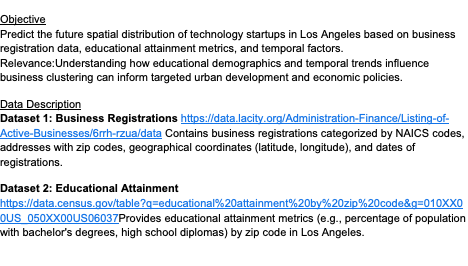

# Data Preparation

### 1. Import Necessary Libraries

In [5]:
import pandas as pd
import zipfile
import os
import tempfile

### 2. Define the directory containing the educational attainment files and load them:

In [8]:
# Define the path to the CSV file
csv_file_path = 'Education Levels.csv'

# Read the CSV file into a DataFrame
education_data = pd.read_csv(csv_file_path, low_memory=False)

# Ensure the GEO_ID column is treated as a string
education_data['GEO_ID'] = education_data['GEO_ID'].astype(str)

# Extract the ZIP_CODE from GEO_ID assuming the format contains 'US' followed by the zip code
education_data['ZipCode'] = education_data['GEO_ID'].str.extract(r'US(\d{5})')[0]

# Replace non-numeric placeholders with NaN
education_data.replace(['(X)', '*****'], pd.NA, inplace=True)

# Drop rows with NaN values in critical columns
education_data = education_data.dropna(subset=['GEO_ID', 'ZipCode'])

# Drop columns with all NaN values
education_data = education_data.dropna(axis=1, how='all')

# Convert columns to numeric, forcing errors to NaN
education_data = education_data.apply(pd.to_numeric, errors='ignore')

# Remove duplicate columns if any
education_data = education_data.loc[:, ~education_data.columns.duplicated()]

# Display the number of missing values per column before imputing
missing_values_before = education_data.isnull().sum()

# Impute missing values for specific columns
columns_to_impute = education_data.columns.difference(['GEO_ID', 'ZipCode'])
education_data[columns_to_impute] = education_data[columns_to_impute].fillna(education_data[columns_to_impute].median(numeric_only=True))

# Display the number of missing values per column after imputing
missing_values_after = education_data.isnull().sum()

print(education_data.head())

           GEO_ID  ZipCode  S1501_C01_001E  S1501_C01_001M S1501_C01_002E  \
1  860Z200US90001    90001            6402             647           1182   
2  860Z200US90002    90002            6710             652           1314   
3  860Z200US90003    90003            7922             555           1740   
4  860Z200US90004    90004            5802             787            819   
5  860Z200US90005    90005            3532             534            526   

  S1501_C01_002M S1501_C01_003E S1501_C01_003M S1501_C01_004E S1501_C01_004M  \
1            288           2254            341           2714            418   
2            293           2794            391           2445            441   
3            366           2833            352           3052            385   
4            303           1410            280           1959            335   
5            221           1147            341           1029            250   

   ... S1501_C06_054E S1501_C06_054M  S1501_C06_055E  S1

In [ ]:
### 2. Define the directory containing the Business Registration file and load:

In [12]:
# Load the business registration data
business_data_path = 'Active_businesses.csv'
business_data = pd.read_csv(business_data_path)

# Inspect the data
print(business_data.head())
print(business_data.info())

  LOCATION ACCOUNT #             BUSINESS NAME           DBA NAME  \
0  0002470296-0003-7                KOMODO LLC             KOMODO   
1  0002829017-0001-5      RICHARD JOHN SHERMAN                NaN   
2  0003260354-0001-2  SOCAL DEMOLITION COMPANY                NaN   
3  0003317944-0001-2            LDE CONSULTING                NaN   
4  0002484826-0001-0               RON FORREST  ALL-RIGHT ROOFING   

          STREET ADDRESS             CITY    ZIP CODE  \
0        235 MAIN STREET           VENICE  90291-5221   
1   2010 LA BREA TERRACE      LOS ANGELES  90046-2314   
2      319 W 18TH STREET    NATIONAL CITY  91950-5525   
3       25692 MOORE LANE  STEVENSON RANCH  91381-1404   
4  1652 E LA DENEY DRIVE          ONTARIO  91764-2222   

       LOCATION DESCRIPTION        MAILING ADDRESS   MAILING CITY  \
0       235 MAIN 90291-5221                    NaN            NaN   
1   2010 LA BREA 90046-2314                    NaN            NaN   
2            319 18TH 91950      31

In [13]:
# Display the columns of the business data to find the correct ZIP code column name
columns = business_data.columns
print("Columns in business data:", columns)
print(business_data.head())

Columns in business data: Index(['LOCATION ACCOUNT #', 'BUSINESS NAME', 'DBA NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
       'MAILING CITY', 'MAILING ZIP CODE', 'NAICS',
       'PRIMARY NAICS DESCRIPTION', 'COUNCIL DISTRICT', 'LOCATION START DATE',
       'LOCATION END DATE', 'LOCATION'],
      dtype='object')
  LOCATION ACCOUNT #             BUSINESS NAME           DBA NAME  \
0  0002470296-0003-7                KOMODO LLC             KOMODO   
1  0002829017-0001-5      RICHARD JOHN SHERMAN                NaN   
2  0003260354-0001-2  SOCAL DEMOLITION COMPANY                NaN   
3  0003317944-0001-2            LDE CONSULTING                NaN   
4  0002484826-0001-0               RON FORREST  ALL-RIGHT ROOFING   

          STREET ADDRESS             CITY    ZIP CODE  \
0        235 MAIN STREET           VENICE  90291-5221   
1   2010 LA BREA TERRACE      LOS ANGELES  90046-2314   
2      319 W 18TH STREET    NATIONAL CITY  91950

In [14]:
# Convert 'LOCATION START DATE' to datetime
business_data['LOCATION START DATE'] = pd.to_datetime(business_data['LOCATION START DATE'], errors='coerce')

# Drop rows with missing 'ZIP CODE'
business_data = business_data.dropna(subset=['ZIP CODE'])

# Ensure 'ZIP CODE' is in the correct format
business_data['ZIP CODE'] = business_data['ZIP CODE'].astype(str).str[:5].str.zfill(5)

# Convert numerical columns to numeric types (if any, you can adjust these columns based on your needs)
# For this example, let's convert 'COUNCIL DISTRICT' to numeric
business_data['COUNCIL DISTRICT'] = pd.to_numeric(business_data['COUNCIL DISTRICT'], errors='coerce')

# Inspect the cleaned data
print("Cleaned Business Data:")
print(business_data.head())

# Display summary of missing values
missing_values = business_data.isnull().sum()
print("\nMissing values after cleaning:")
print(missing_values)

Cleaned Business Data:
  LOCATION ACCOUNT #             BUSINESS NAME           DBA NAME  \
0  0002470296-0003-7                KOMODO LLC             KOMODO   
1  0002829017-0001-5      RICHARD JOHN SHERMAN                NaN   
2  0003260354-0001-2  SOCAL DEMOLITION COMPANY                NaN   
3  0003317944-0001-2            LDE CONSULTING                NaN   
4  0002484826-0001-0               RON FORREST  ALL-RIGHT ROOFING   

          STREET ADDRESS             CITY ZIP CODE      LOCATION DESCRIPTION  \
0        235 MAIN STREET           VENICE    90291       235 MAIN 90291-5221   
1   2010 LA BREA TERRACE      LOS ANGELES    90046   2010 LA BREA 90046-2314   
2      319 W 18TH STREET    NATIONAL CITY    91950            319 18TH 91950   
3       25692 MOORE LANE  STEVENSON RANCH    91381    25692 MOORE 91381-1404   
4  1652 E LA DENEY DRIVE          ONTARIO    91764  1652 LA DENEY 91764-2222   

         MAILING ADDRESS   MAILING CITY MAILING ZIP CODE  NAICS  \
0             

# ##Merge business registration with educational attainment

In [12]:
import pandas as pd

# Load the data
education_data = pd.read_csv('/Users/admin/Desktop/education_data_cleaned.csv', low_memory=False)
business_data = pd.read_csv('/Users/admin/Desktop/business_data_cleaned.csv', low_memory=False)

print("Data loaded successfully.")

Data loaded successfully.


In [14]:
# Strip any leading or trailing spaces from column names
education_data.columns = education_data.columns.str.strip()
business_data.columns = business_data.columns.str.strip()

# Inspect columns of both DataFrames
print("Education Data Columns:", education_data.columns)
print("Business Data Columns:", business_data.columns)

Education Data Columns: Index(['GEO_ID', 'ZipCode', 'S1501_C01_001E', 'S1501_C01_001M',
       'S1501_C01_002E', 'S1501_C01_002M', 'S1501_C01_003E', 'S1501_C01_003M',
       'S1501_C01_004E', 'S1501_C01_004M',
       ...
       'S1501_C06_054M', 'S1501_C06_055E', 'S1501_C06_055M', 'S1501_C06_056E',
       'S1501_C06_056M', 'S1501_C06_057E', 'S1501_C06_057M', 'S1501_C06_058E',
       'S1501_C06_058M', 'Cleaned_ZipCode'],
      dtype='object', length=641)
Business Data Columns: Index(['LOCATION ACCOUNT #', 'BUSINESS NAME', 'DBA NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
       'MAILING CITY', 'MAILING ZIP CODE', 'NAICS',
       'PRIMARY NAICS DESCRIPTION', 'COUNCIL DISTRICT', 'LOCATION START DATE',
       'LOCATION END DATE', 'LOCATION', 'Cleaned_ZipCode'],
      dtype='object')


In [15]:
# Strip any leading or trailing spaces from column names
education_data.columns = education_data.columns.str.strip()
business_data.columns = business_data.columns.str.strip()

# Verify column names again
print("Education Data Columns After Stripping:", education_data.columns)
print("Business Data Columns After Stripping:", business_data.columns)

Education Data Columns After Stripping: Index(['GEO_ID', 'ZipCode', 'S1501_C01_001E', 'S1501_C01_001M',
       'S1501_C01_002E', 'S1501_C01_002M', 'S1501_C01_003E', 'S1501_C01_003M',
       'S1501_C01_004E', 'S1501_C01_004M',
       ...
       'S1501_C06_054M', 'S1501_C06_055E', 'S1501_C06_055M', 'S1501_C06_056E',
       'S1501_C06_056M', 'S1501_C06_057E', 'S1501_C06_057M', 'S1501_C06_058E',
       'S1501_C06_058M', 'Cleaned_ZipCode'],
      dtype='object', length=641)
Business Data Columns After Stripping: Index(['LOCATION ACCOUNT #', 'BUSINESS NAME', 'DBA NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
       'MAILING CITY', 'MAILING ZIP CODE', 'NAICS',
       'PRIMARY NAICS DESCRIPTION', 'COUNCIL DISTRICT', 'LOCATION START DATE',
       'LOCATION END DATE', 'LOCATION', 'Cleaned_ZipCode'],
      dtype='object')


In [16]:
# Ensure 'Cleaned_ZipCode' columns are strings and stripped
education_data['Cleaned_ZipCode'] = education_data['Cleaned_ZipCode'].astype(str).str.strip()
business_data['Cleaned_ZipCode'] = business_data['Cleaned_ZipCode'].astype(str).str.strip()

# Print sample values to verify
print("Education Data 'Cleaned_ZipCode' Sample:")
print(education_data['Cleaned_ZipCode'].head(10))

print("Business Data 'Cleaned_ZipCode' Sample:")
print(business_data['Cleaned_ZipCode'].head(10))

Education Data 'Cleaned_ZipCode' Sample:
0    90001
1    90002
2    90003
3    90004
4    90005
5    90006
6    90007
7    90008
8    90010
9    90011
Name: Cleaned_ZipCode, dtype: object
Business Data 'Cleaned_ZipCode' Sample:
0    90291
1    90046
2    91950
3    91381
4    91764
5    91311
6    90012
7    90014
8    92104
9    90003
Name: Cleaned_ZipCode, dtype: object


In [28]:
# Check the unique cleaned ZIP codes in both datasets
education_zip_codes = set(education_data['Cleaned_ZipCode'].unique())
business_zip_codes = set(business_data['Cleaned_ZipCode'].unique())

# Find common ZIP codes
common_zip_codes = education_zip_codes.intersection(business_zip_codes)
print(f"Step 2: Found {len(common_zip_codes)} common ZIP codes.")
print(f"Common ZIP codes: {common_zip_codes}")

Step 2: Found 171 common ZIP codes.
Common ZIP codes: {'90813', '90066', '90293', '90712', '90746', '90304', '90606', '90621', '90804', '90059', '90620', '90640', '90023', '90250', '90638', '90650', '90016', '90069', '90272', '90743', '90045', '90255', '90402', '90503', '90040', '90720', '90275', '90036', '90013', '90022', '90027', '90047', '90220', '90404', '90035', '90660', '90038', '90094', '90240', '90723', '90704', '90670', '90405', '90043', '90603', '90048', '90403', '90012', '90068', '90265', '90731', '90019', '90014', '90015', '90810', '90740', '90064', '90502', '90063', '90742', '90505', '90026', '90004', '90274', '90713', '90211', '90042', '90001', '90221', '90254', '90302', '90248', '90401', '90744', '90623', '90056', '90241', '90057', '90006', '90247', '90033', '90303', '90003', '90010', '90266', '90290', '90814', '90263', '90277', '90716', '90222', '90049', '90706', '90002', '90007', '90305', '90037', '90052', '90602', '90028', '90292', '90805', '90802', '90021', '90018', 

In [18]:
# Create new DataFrames with only the common ZIP codes
education_data_common = education_data[education_data['Cleaned_ZipCode'].isin(common_zip_codes)]
business_data_common = business_data[business_data['Cleaned_ZipCode'].isin(common_zip_codes)]

print("Step 3: DataFrames with common ZIP codes created.")
print(f"Size of education_data_common: {education_data_common.shape}")
print(f"Size of business_data_common: {business_data_common.shape}")


Step 3: DataFrames with common ZIP codes created.
Size of education_data_common: (2040, 641)
Size of business_data_common: (342333, 17)


In [19]:
print("Starting Step 4...")

# Merge the datasets on the common cleaned ZIP codes
try:
    print("Attempting to merge datasets...")

    # Perform the full merge
    merged_data = pd.merge(education_data_common, business_data_common, on='Cleaned_ZipCode', suffixes=('_edu', '_biz'))
    print("Datasets merged successfully.")
    print(merged_data.head())

except Exception as e:
    print(f"Error during merging: {e}")

# Display the first few rows of the merged data
try:
    print("Attempting to display merged data sample...")
    print(merged_data.head())
except Exception as e:
    print(f"Error displaying merged data: {e}")

print("Step 4 completed.")

Starting Step 4...
Attempting to merge datasets...
Datasets merged successfully.
           GEO_ID  ZipCode  S1501_C01_001E  S1501_C01_001M S1501_C01_002E  \
0  860Z200US90001    90001            6402             647           1182   
1  860Z200US90001    90001            6402             647           1182   
2  860Z200US90001    90001            6402             647           1182   
3  860Z200US90001    90001            6402             647           1182   
4  860Z200US90001    90001            6402             647           1182   

  S1501_C01_002M S1501_C01_003E S1501_C01_003M S1501_C01_004E S1501_C01_004M  \
0            288           2254            341           2714            418   
1            288           2254            341           2714            418   
2            288           2254            341           2714            418   
3            288           2254            341           2714            418   
4            288           2254            341          

In [33]:
import pandas as pd
from tqdm import tqdm

# Assuming merged_data is already created and loaded

# Set the chunk size
chunk_size = 100000  

# Define the file path
file_path = '/Users/admin/Desktop/merged_education_business_data.csv'

# Initialize the CSV file by writing the header
merged_data.head(0).to_csv(file_path, index=False)

# Save the DataFrame in chunks
num_chunks = len(merged_data) // chunk_size + 1

print("Saving the merged dataset in chunks...")
for start in tqdm(range(0, len(merged_data), chunk_size), total=num_chunks):
    merged_data[start:start + chunk_size].to_csv(file_path, mode='a', header=False, index=False)

print("Merged dataset saved in chunks successfully.")

Saving the merged dataset in chunks...


100%|███████████████████████████████████████████| 42/42 [18:07<00:00, 25.89s/it]

Merged dataset saved in chunks successfully.


In [ ]:
import pandas as pd

# Define the file path
file_path = '/Users/admin/Desktop/merged_education_business_data.csv'

# Read the CSV file into a DataFrame
prelim_data = pd.read_csv(file_path, low_memory=False)

# Define the list of columns to keep
education_columns = ['GEO_ID', 'ZipCode'] + \
                    [f'S1401_C04_0{i}E' for i in range(10, 13)] + \
                    [f'S1501_C01_{i:03d}E' for i in range(1, 28)] + \
                    [f'S1502_C01_{i:03d}E' for i in range(1, 25)]

# Ensure all columns in the list are present in the DataFrame
prelim_columns = [col for col in education_columns if col in prelim_data.columns]

# Print columns that are not found to troubleshoot any discrepancies
missing_columns = [col for col in education_columns if col not in prelim_data.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")

# Select relevant columns from the dataframe
education_data = prelim_data[prelim_columns]

# Display the first few rows to confirm selection
print(education_data.head())